In [1]:
# 업데이트 내용
# 건물연식과 계약날짜 검색범위 조정할 필요 없이 가장 자주 쓰이는 건물연식, 계약날짜 조합 파일들 전부 생성

In [2]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [3]:
target_gu = '금천구' # 구 명
target_dong = '가산' # 동 명: 동 명에서 마지막 글자 '동' 뺄 것
#target_purpose = '준주거' # 종 명: 건드릴 필요 없음
target_building_age = 3 # 건물연식: 건드릴 필요 없음
target_period = 36 # 계약날짜 검색범위: 건드릴 필요 없음

In [4]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [5]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210802'

In [6]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [7]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [8]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [9]:
apart_df = data_prep('아파트', '매매')
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:02,  6.36it/s]


(1205093, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,59500,7,1988,18,2006-03-10,765.273312,33,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,6,1988,18,2006-03-29,771.704180,33,아파트
2,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,67000,9,1988,18,2006-04-29,861.736334,33,아파트
3,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,4,1988,18,2006-06-01,771.704180,33,아파트
4,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,72250,5,1988,18,2006-10-20,929.260450,33,아파트


In [10]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01,  9.23it/s]


(645994, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [11]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 33.30it/s]


(183662, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [12]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(2034749, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),71.72,64500,7,2000.0,17.0,2017-09-23,899.330731,21.0,아파트
4,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,29800,4,2000.0,6.0,2006-10-18,405.442177,21.0,아파트


In [13]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [14]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [15]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [16]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [17]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= 1)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(198, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동
652276,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,17.44,19800,9,2020.0,0.0,2020-11-28,1135.321101,1.0,연립다세대,금천구,가산동
652277,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,0.0,2020-11-17,855.661193,1.0,오피스텔,금천구,가산동
652278,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,0.0,2020-12-03,855.661193,1.0,오피스텔,금천구,가산동
652279,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,1.0,2021-01-27,855.661193,1.0,오피스텔,금천구,가산동


In [18]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= 2)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(392, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동


In [19]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= 3)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(543, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동


In [20]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=60)))
    &(house_df['건물연식'] <= 5)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(743, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동


In [21]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [22]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [23]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [24]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(198, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06
652276,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,17.44,19800,9,2020.0,0.0,2020-11-28,1135.321101,1.0,연립다세대,금천구,가산동,1206.475488,2021-05-01
652277,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,0.0,2020-11-17,855.661193,1.0,오피스텔,금천구,가산동,909.288354,2021-05-01
652278,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,0.0,2020-12-03,855.661193,1.0,오피스텔,금천구,가산동,903.048658,2021-05-01
652279,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.14,19800,7,2020.0,1.0,2021-01-27,855.661193,1.0,오피스텔,금천구,가산동,891.832479,2021-05-01


In [25]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(392, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동,855.691743,2021-05-01
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동,956.478355,2021-05-01
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01


In [26]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(543, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동,855.691743,2021-05-01
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동,956.478355,2021-05-01
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01


In [27]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(743, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06
652235,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,16.95,12500,1,2019.0,1.0,2020-03-26,737.463127,2.0,오피스텔,금천구,가산동,855.691743,2021-05-01
652236,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,18300,9,2019.0,1.0,2020-03-01,824.324324,2.0,오피스텔,금천구,가산동,956.478355,2021-05-01
652237,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,4,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01
652238,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,22.20,17000,5,2019.0,1.0,2020-03-02,765.765766,2.0,오피스텔,금천구,가산동,888.531805,2021-05-01


In [28]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식1년_최근12개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [29]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식2년_최근24개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [30]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식3년_최근36개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [31]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식5년_최근60개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [32]:
target_df = target_3_36_df.copy()

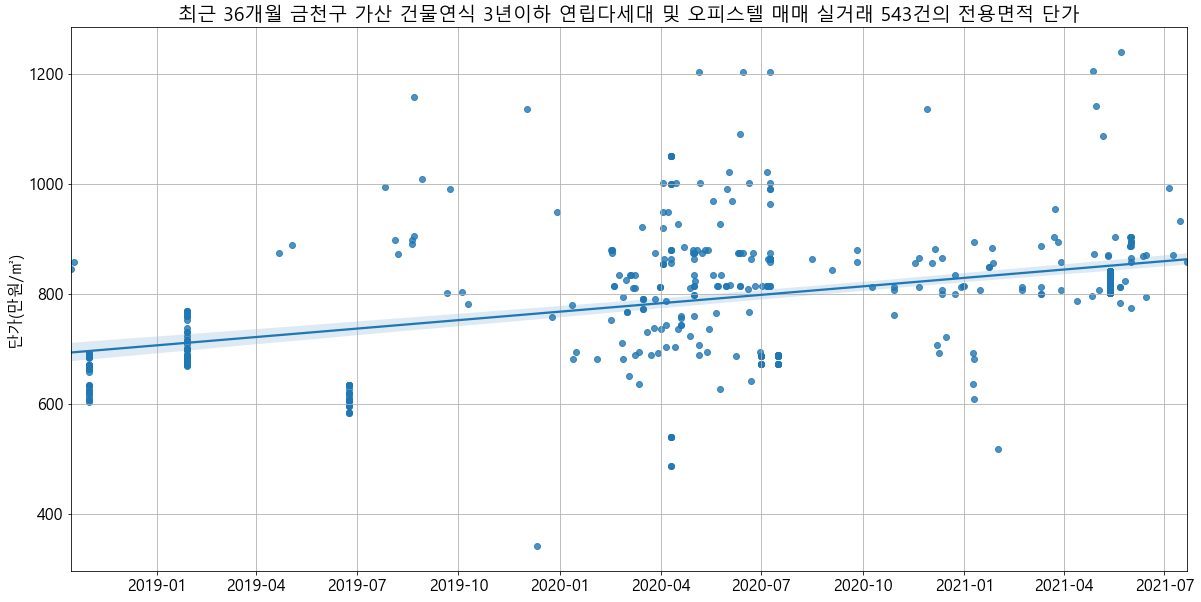

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [34]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

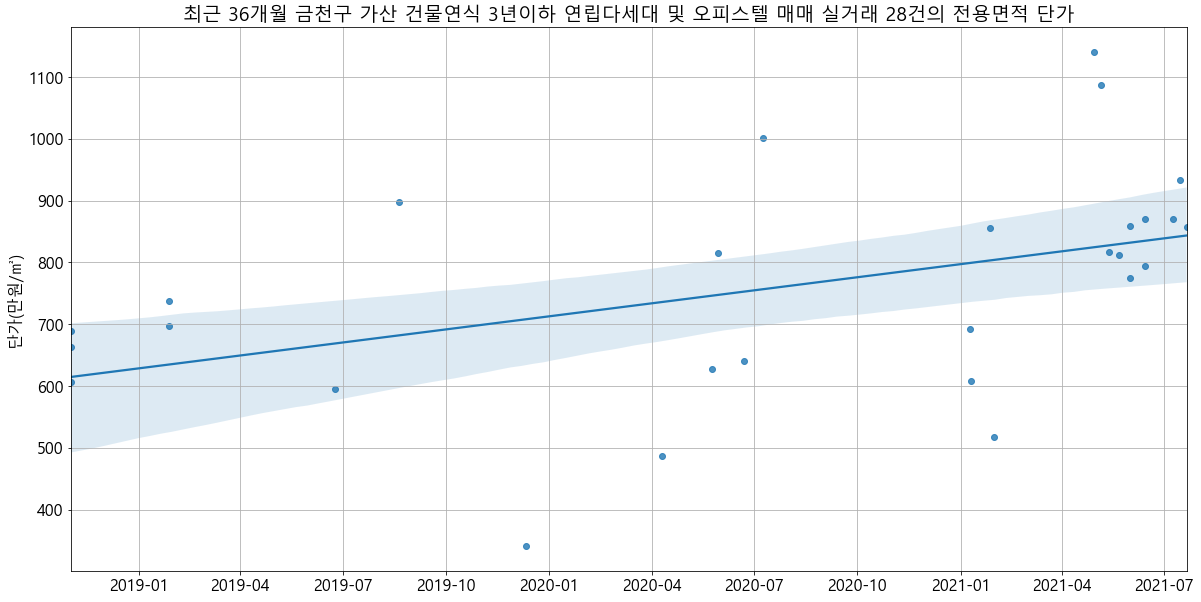

In [35]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [36]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [37]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1567, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
652164,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동
652165,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,19.96,12871,5,2013.0,0.0,2013-09-30,644.839679,8.0,오피스텔,금천구,가산동
652166,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,19.96,13608,4,2013.0,0.0,2013-12-20,681.763527,8.0,오피스텔,금천구,가산동
652167,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,19.96,14241,8,2013.0,0.0,2013-12-20,713.476954,8.0,오피스텔,금천구,가산동
652168,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,19.96,14930,13,2013.0,0.0,2013-12-21,747.995992,8.0,오피스텔,금천구,가산동


In [38]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'금천구 가산 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 1567건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

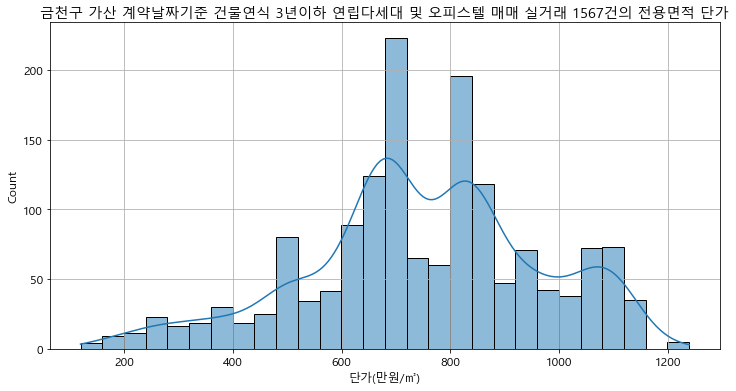

In [39]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [40]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [41]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [42]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [43]:
concat_df = pd.concat([target_df2])

In [44]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [45]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [46]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(246, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.52,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06,1086.482558,1086.482558
1,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,19.96,13500,8,2013.0,3.0,2016-12-22,676.352705,8.0,오피스텔,금천구,가산동,911.957883,2021-05-01,711.527445,1011.380293
2,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,21.38,14750,14,2013.0,3.0,2016-06-10,689.897100,8.0,오피스텔,금천구,가산동,956.149457,2021-05-01,711.527445,1011.380293
3,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,32.27,23000,16,2013.0,3.0,2016-03-10,712.736288,8.0,오피스텔,금천구,가산동,995.638863,2021-05-01,711.527445,1011.380293
4,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,34.28,26297,16,2013.0,0.0,2013-12-20,767.123687,8.0,오피스텔,금천구,가산동,1181.774967,2021-05-01,711.527445,1011.380293


In [47]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(86, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 금천구 가산동 139-15,디지털로 207,G밸리 페트라 힐스,27.5200,29900,11,2020.0,1.0,2021-05-06,1086.482558,1.0,아파트,금천구,가산동,1086.482558,2021-05-06,1086.482558,1086.482558
4,서울특별시 금천구 가산동 139-3,벚꽃로56길 182,램킨푸르지오시티,34.2800,26297,16,2013.0,0.0,2013-12-20,767.123687,8.0,오피스텔,금천구,가산동,1181.774967,2021-05-01,711.527445,1011.380293
8,서울특별시 금천구 가산동 140-15,디지털로 208-25,세림프라미스,23.9400,19500,10,2019.0,1.0,2020-05-30,814.536341,2.0,오피스텔,금천구,가산동,936.201520,2021-05-01,787.290180,906.904587
10,서울특별시 금천구 가산동 140-20,디지털로 208-13,라온복합건물,23.1400,19800,7,2020.0,1.0,2021-01-27,855.661193,1.0,오피스텔,금천구,가산동,891.832479,2021-05-01,995.491147,1049.153983
13,서울특별시 금천구 가산동 140-23,디지털로 208-9,몽삐에뜨6차,29.4800,25300,3,2020.0,1.0,2021-06-01,858.208955,1.0,오피스텔,금천구,가산동,858.208955,2021-06-01,852.861509,852.861509
23,서울특별시 금천구 가산동 140-36,디지털로12길 15,비즈트위트바이올렛5차,30.3700,23900,15,2014.0,2.0,2016-08-18,786.960817,7.0,아파트,금천구,가산동,1069.859139,2021-05-01,870.674497,1191.739944
40,서울특별시 금천구 가산동 140-9,가산로 147,가산지웰에스테이트,33.1400,30291,7,2013.0,2.0,2015-03-05,914.031382,8.0,아파트,금천구,가산동,1339.192258,2021-05-01,769.239595,1084.420021
44,서울특별시 금천구 가산동 141-2,남부순환로 1266,가산 양우 내안애 애플,23.4400,15500,6,2013.0,3.0,2016-06-14,661.262799,8.0,오피스텔,금천구,가산동,916.464305,2021-05-01,852.069021,1152.706190
47,서울특별시 금천구 가산동 142-17,남부순환로108길 20-34,스마트캐슬,54.4000,28500,5,2016.0,3.0,2019-11-20,523.897059,5.0,연립다세대,금천구,가산동,604.693176,2021-05-01,552.364492,664.772161
48,서울특별시 금천구 가산동 142-33,남부순환로108길 24,로뎀아트빌,58.9900,30500,2,2018.0,3.0,2021-01-31,517.036786,3.0,오피스텔,금천구,가산동,538.893434,2021-05-01,517.036786,538.893434


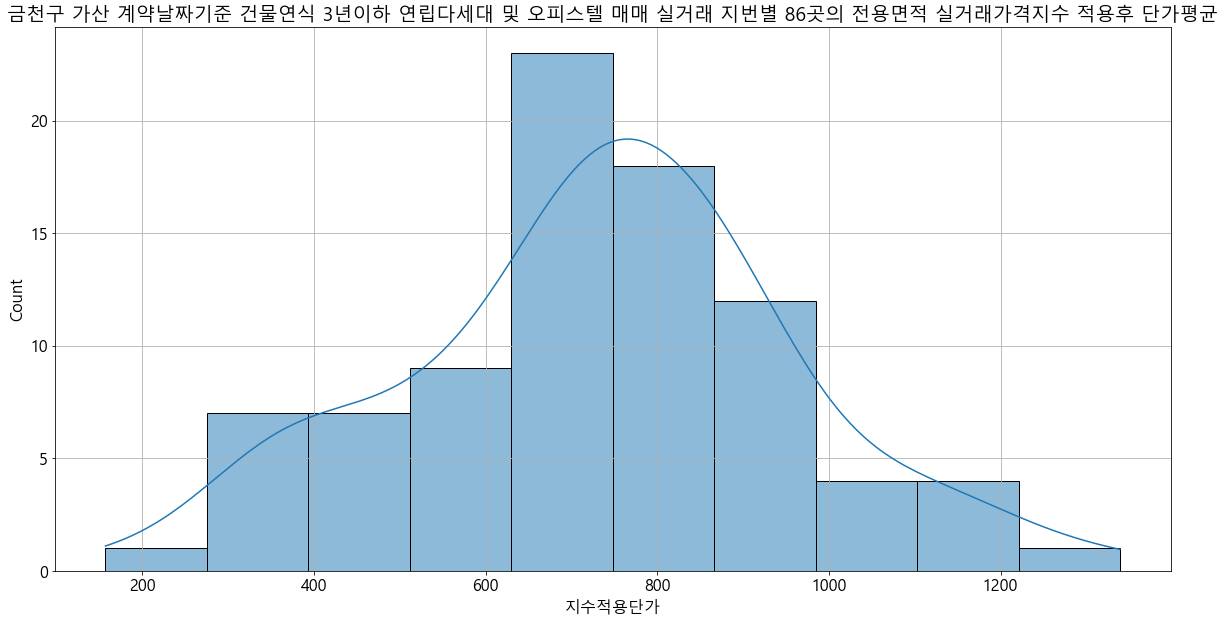

In [48]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [49]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [50]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 금천구 가산동 139-15,G밸리 페트라 힐스,2020.0,27.52,11,2021-05-06,1086.482558,2021-05-06,1086.482558,아파트
1,서울특별시 금천구 가산동 139-3,램킨푸르지오시티,2013.0,34.28,16,2013-12-20,767.123687,2021-05-01,1181.774967,오피스텔
2,서울특별시 금천구 가산동 140-15,세림프라미스,2019.0,23.94,10,2020-05-30,814.536341,2021-05-01,936.201520,오피스텔
3,서울특별시 금천구 가산동 140-20,라온복합건물,2020.0,23.14,7,2021-01-27,855.661193,2021-05-01,891.832479,오피스텔
4,서울특별시 금천구 가산동 140-23,몽삐에뜨6차,2020.0,29.48,3,2021-06-01,858.208955,2021-06-01,858.208955,오피스텔


In [51]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)